In [ ]:
!pip install torch torchvision torchaudio
# Install torch-scatter
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-sparse
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-cluster
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Install torch-geometric
!pip install torch-geometric

In [1]:
!pip install pandas
!pip install networkx

import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
# from google.colab import files

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
dataset_path = 'simulator_data.csv'
# dataset_path = '/content/simulator_data.csv'
# df = pd.read_csv(dataset_path)


In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from torch_geometric.data import Data
import numpy as np

# Load the dataset
# dataset_path = "path_to_your_dataset.csv"  # Replace with your actual dataset path
data = pd.read_csv(dataset_path)

# Function to compute the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


In [4]:
# Function to check for handovers between timestamps
def check_handovers(df, current_timestamp, next_timestamp):
    current_data = df[df['timestamp'] == current_timestamp]
    next_data = df[df['timestamp'] == next_timestamp]

    handovers = {}
    for vid in current_data['vehicleId'].unique():
        current_master = current_data[current_data['vehicleId'] == vid]['masterId'].iloc[0]
        next_master = next_data[next_data['vehicleId'] == vid]['masterId'].iloc[0] if vid in next_data['vehicleId'].values else current_master
        handovers[vid] = current_master != next_master

    return handovers

In [5]:
# Function to create a graph data object and NetworkX graph for a given timestamp
def create_graph_data_for_timestamp(df, timestamp):
    timestamp_data = df[df['timestamp'] == timestamp]
    vehicle_ids = timestamp_data['vehicleId'].unique()
    print('number of vehicles:', vehicle_ids.size)
    tower_ids = timestamp_data['towerId'].unique()
    print('number of towers:', tower_ids.size)
    vehicle_mapping = {vid: i for i, vid in enumerate(vehicle_ids)}
    tower_mapping = {tid: i + len(vehicle_ids) for i, tid in enumerate(tower_ids)}

    node_features = []
    edge_index = []
    edge_features = []

    G = nx.Graph()  # NetworkX Graph for visualization

    # Process vehicle nodes
    for vid in vehicle_ids:
        try:
            vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[2]
        except IndexError:
            try:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[1]
            except IndexError:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_features = [
            vehicle_data['vehicleSpeed'], vehicle_data['vehicleDirection'], vehicle_data['vehiclePosX'],
            vehicle_data['vehiclePosY']
        ]
        node_features.append(vehicle_features)
        G.add_node(vehicle_mapping[vid], speed=vehicle_data['vehicleSpeed'], dir=vehicle_data['vehicleDirection'], 
                  pos=(vehicle_data['vehiclePosX'], vehicle_data['vehiclePosY']),
                   type='vehicle', label=f'{vid}')

    # Process tower nodes
    for tid in tower_ids:
        master_data = timestamp_data[timestamp_data['masterId'] == tid][::-1]
        if not master_data.empty:
            tower_data = master_data.iloc[0]
            tower_features = [
                tower_data['masterPosX'], tower_data['masterPosY'],
                tower_data['masterLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['masterPosX'], tower_data['masterPosY']), load=tower_data['masterLoad'],
                    type='tower', label=f'T{tid}')
        else:
            tower_data = timestamp_data[timestamp_data['towerId'] == tid][::-1].iloc[0]
            tower_features = [
                tower_data['towerPosX'], tower_data['towerPosY'],
                tower_data['towerLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['towerPosX'], tower_data['towerPosY']), load=tower_data['towerLoad'],
                        type='tower', label=f'T{tid}')

        node_features.append(tower_features)
        

    # Add edges based on the masterId
    for _, row in timestamp_data.iterrows():
        vehicle_id = vehicle_mapping[row['vehicleId']]
        tower_id = tower_mapping[row['masterId']]  # Connect to the master tower
        edge_index.append([vehicle_id, tower_id])
        

        distance = calculate_distance(row['vehiclePosX'], row['vehiclePosY'],
                                      row['masterPosX'], row['masterPosY'])
        edge_features.append([row['throughput'], row['masterRssi'], distance])

        # Add edges to the NetworkX graph
        G.add_edge(vehicle_id, tower_id, throughput=row['throughput'],  rssi=row['masterRssi'], distance=distance)
    
    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # print(edge_index_tensor)
    # print(len(edge_index))
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)
    print("node features: ", graph_data.x.shape,"edge index: ", graph_data.edge_index.shape,"edge attr: ", graph_data.edge_attr.shape)
    return graph_data, G, vehicle_mapping, tower_mapping

In [6]:
def preprocess_graph_data(graph_data, vehicle_mapping):
    max_RSSI_for_vehicles = {}
    min_RSSI_or_max_distance_for_vehicles = {}

    for vehicle_id, vehicle_idx in vehicle_mapping.items():
        # Filter edges for the current vehicle
        vehicle_edges = (graph_data.edge_index[0] == vehicle_idx).nonzero().squeeze()
        
        if vehicle_edges.numel() == 0:
            continue  # No edges for this vehicle

        # Get RSSI values for these edges
        vehicle_RSSI_values = graph_data.edge_attr[vehicle_edges, 0]
        vehicle_distance_values = graph_data.edge_attr[vehicle_edges, 1]

        # Find the max RSSI value
        max_RSSI = torch.max(vehicle_RSSI_values)
        max_RSSI_for_vehicles[vehicle_id] = max_RSSI.item()

        # Option 1: Min RSSI for negative samples
        min_RSSI = torch.min(vehicle_RSSI_values)
        
        # Option 2: Max distance for negative samples
        max_distance = torch.max(vehicle_distance_values)

        # Assuming min RSSI is chosen for negative samples, adjust as needed
        min_RSSI_or_max_distance_for_vehicles[vehicle_id] = min_RSSI.item()
        
        # print(max_RSSI_for_vehicles)
        # print(min_RSSI_or_max_distance_for_vehicles)
        # Uncomment the following line if using max distance instead
        # min_RSSI_or_max_distance_for_vehicles[vehicle_id] = max_distance.item()

    return max_RSSI_for_vehicles, min_RSSI_or_max_distance_for_vehicles

In [31]:
graph_data, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(data,20)
# preprocess_graph_data(graph_data,vehicle_mapping)

number of vehicles: 100
number of towers: 10
node features:  torch.Size([110, 4]) edge index:  torch.Size([2, 187]) edge attr:  torch.Size([187, 3])


In [7]:
# Visualization function
def visualize_graph(G, handovers, vehicle_mapping, tower_mapping):
    # Set node attributes for vehicle and tower IDs and colors
    for node in G.nodes:
        node_info = G.nodes[node]
        node_type = node_info['type']
        if node_type == 'vehicle':
            label = node_info['label']
            color = 'lightblue'  # Color for vehicles
        elif node_type == 'tower':
            label = node_info['label']
            color = 'lightgreen'  # Color for towers
        else:
            label = 'Unknown'
            color = 'gray'

        G.nodes[node]['label'] = label
        G.nodes[node]['color'] = color

    # Highlight handover nodes
    for vehicle_id, handover in handovers.items():
        if handover:
            node = vehicle_mapping.get(vehicle_id)
            if node is not None:
                G.nodes[node]['color'] = 'lightpink'  # Highlight color for handovers

    # Set edge attributes for master RSSI
    for u, v in G.edges:
        edge_data = G[u][v]
        # Ensure that the 'masterRssi' key is correctly named as per your data
        master_rssi = edge_data.get('rssi', 0.0)  # Default to 'N/A' if not available
        G.edges[u, v]['label'] = str(int(master_rssi))

    # Prepare colors for nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes]

    # Visualize the graph
    pos = nx.get_node_attributes(G, 'pos')
    scale_factor = 100
    # Scale the x and y coordinates of each node
    scaled_pos = {node: (x * scale_factor, y * scale_factor) for node, (x, y) in pos.items()}
    nx.set_node_attributes(G, scaled_pos, 'pos')

    nx.draw(G, pos=scaled_pos, node_color=node_colors, with_labels=True, labels=nx.get_node_attributes(G, 'label'),font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos=scaled_pos, edge_labels=nx.get_edge_attributes(G, 'label'),font_size=8)

    
def visualize_for_timestamp_range(df, start_timestamp, end_timestamp=None):
    if end_timestamp is not None:
        # Visualize graphs for the specified range
        timestamps = df['timestamp'].unique()
        timestamps_in_range = [t for t in timestamps if start_timestamp <= t <= end_timestamp]

        for timestamp in timestamps_in_range:
            # Get the next timestamp in the sequence for handover comparison
            next_timestamp_index = np.where(timestamps == timestamp)[0][0] + 1
            if next_timestamp_index < len(timestamps):
                next_timestamp = timestamps[next_timestamp_index]
            else:
                next_timestamp = timestamp  # No handover if it's the last timestamp

            # Check for handovers and create the graph for the current timestamp
            handovers = check_handovers(df, timestamp, next_timestamp)
            _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, timestamp)

            # Visualize the graph
            plt.figure(figsize=(12, 8))
            visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
            plt.title(f'Network Graph at Timestamp {timestamp}')
            plt.show()
    else:
        # Visualize a single graph for start_timestamp to start_timestamp + 0.5
        _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, start_timestamp)   
        handovers = check_handovers(df, start_timestamp, start_timestamp + 0.5) 
        plt.figure(figsize=(12, 8))
        visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
        plt.title(f'Network Graph at Timestamp {start_timestamp}')
        plt.show()

# visualize_for_timestamp_range(data, start_timestamp=69.5, end_timestamp=70)

number of vehicles: 97
number of towers: 10
node features:  torch.Size([107, 4]) edge index:  torch.Size([2, 174]) edge attr:  torch.Size([174, 3])


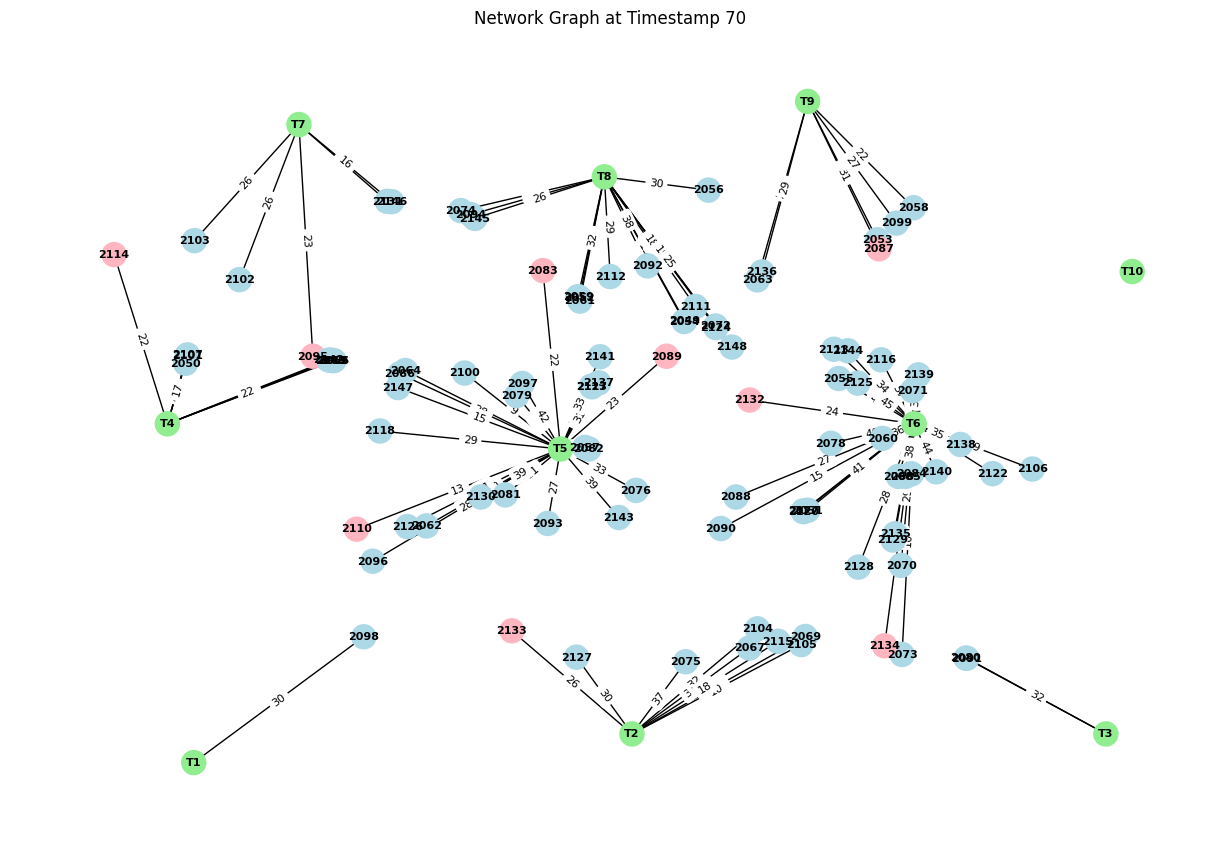

In [8]:
visualize_for_timestamp_range(data, start_timestamp=70)

In [27]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)  # Include edge_index here
        return x

In [28]:
from torch_geometric.loader import DataLoader

# Example of preparing the data
graph_data, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(data, 70)
print(vehicle_mapping)
print(tower_mapping)
print(graph_data.num_node_features)

# Create a DataLoader
loader = DataLoader([graph_data], batch_size=32, shuffle=True)

number of vehicles: 97
number of towers: 10
node features:  torch.Size([107, 4]) edge index:  torch.Size([2, 174]) edge attr:  torch.Size([174, 3])
{2098: 0, 2067: 1, 2069: 2, 2075: 3, 2090: 4, 2093: 5, 2104: 6, 2105: 7, 2115: 8, 2127: 9, 2133: 10, 2143: 11, 2073: 12, 2080: 13, 2091: 14, 2134: 15, 2050: 16, 2064: 17, 2066: 18, 2086: 19, 2095: 20, 2096: 21, 2101: 22, 2102: 23, 2103: 24, 2107: 25, 2109: 26, 2110: 27, 2114: 28, 2118: 29, 2119: 30, 2142: 31, 2147: 32, 2049: 33, 2052: 34, 2054: 35, 2057: 36, 2059: 37, 2061: 38, 2062: 39, 2072: 40, 2076: 41, 2077: 42, 2079: 43, 2081: 44, 2082: 45, 2083: 46, 2088: 47, 2089: 48, 2092: 49, 2097: 50, 2100: 51, 2111: 52, 2112: 53, 2117: 54, 2123: 55, 2124: 56, 2126: 57, 2130: 58, 2132: 59, 2137: 60, 2141: 61, 2148: 62, 2051: 63, 2053: 64, 2055: 65, 2058: 66, 2060: 67, 2063: 68, 2068: 69, 2070: 70, 2071: 71, 2078: 72, 2084: 73, 2085: 74, 2087: 75, 2099: 76, 2106: 77, 2113: 78, 2116: 79, 2120: 80, 2122: 81, 2125: 82, 2128: 83, 2129: 84, 2135: 85, 2

In [29]:
import torch.nn.functional as F
def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

In [56]:
import random

def get_triplets(data, embeddings, vehicle_mapping, tower_mapping):
    anchors = []
    positives = []
    negatives = []

    # print(data.edge_index)
    for vehicle_id in vehicle_mapping.values():
        # vehicle_idx = vehicle_mapping[vehicle_id]
        # print(vehicle_idx)

        # Get the indices of towers connected to this vehicle (positive samples)
        # connected_towers = [tower_mapping[tid] for tid in data.edge_index[1][data.edge_index[0] == vehicle_idx].tolist()]
        connected_towers = data.edge_index[1][data.edge_index[0] == vehicle_id].tolist()

        if not connected_towers:
            continue

        # Select one connected tower as positive
        positive_idx = random.choice(connected_towers)

        # Select one non-connected tower as negative
        non_connected_towers = list(set(tower_mapping.values()) - set(connected_towers))
        if not non_connected_towers:
            continue
        negative_idx = random.choice(non_connected_towers)

        anchors.append(embeddings[vehicle_id])
        positives.append(embeddings[positive_idx])
        negatives.append(embeddings[negative_idx])

    # Convert to tensors
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)

    return anchors, positives, negatives

In [ ]:
def get_triplets(graph_data, vehicle_mapping, tower_mapping):
    anchors = []
    positives = []
    negatives = []

    # Assuming you have a way to access RSSI and distance information for each vehicle-tower pair
    # This could be stored in graph_data.edge_attr or another structure

    for vehicle_id, vehicle_idx in vehicle_mapping.items():
        # Find the tower with the strongest RSSI (positive sample)
        connected_towers_idxs = [edge_index for edge_index, (v_id, t_id) in enumerate(zip(graph_data.edge_index[0], graph_data.edge_index[1]))
                                 if v_id == vehicle_idx and graph_data.edge_attr[edge_index][1] == max_RSSI_for_that_vehicle]
        
        if connected_towers_idxs:
            positive_idx = random.choice(connected_towers_idxs)  # If multiple, choose randomly

            # Find the tower with the weakest RSSI or farthest distance (negative sample)
            negative_idxs = [edge_index for edge_index, (v_id, t_id) in enumerate(zip(graph_data.edge_index[0], graph_data.edge_index[1]))
                             if v_id == vehicle_idx and graph_data.edge_attr[edge_index][1] == min_RSSI_or_max_distance_for_that_vehicle]

            if negative_idxs:
                negative_idx = random.choice(negative_idxs)  # If multiple, choose randomly

                anchors.append(vehicle_idx)
                positives.append(graph_data.edge_index[1][positive_idx])  # Tower index
                negatives.append(graph_data.edge_index[1][negative_idx])  # Tower index

    # Convert indices to embeddings
    anchors_embeddings = embeddings[anchors]
    positives_embeddings = embeddings[positives]
    negatives_embeddings = embeddings[negatives]

    return anchors_embeddings, positives_embeddings, negatives_embeddings

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_node_features=graph_data.num_node_features, hidden_channels=64, out_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    total_loss = 0
    for data in loader:
        # print(data)
        data = data.to(device)
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)
        # print(embeddings.shape)

        anchors, positives, negatives = get_triplets(data, embeddings, vehicle_mapping, tower_mapping)
        loss = triplet_loss(anchors, positives, negatives)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(loader)}')

Epoch 1, Loss: 69594944.0
Epoch 2, Loss: 30659342.0
Epoch 3, Loss: 11945172.0
Epoch 4, Loss: 4544152.5
Epoch 5, Loss: 3607818.5
Epoch 6, Loss: 3992979.75
Epoch 7, Loss: 4423234.5
Epoch 8, Loss: 5410320.5
Epoch 9, Loss: 4996952.5
Epoch 10, Loss: 4213062.5
Epoch 11, Loss: 4211780.0
Epoch 12, Loss: 3854577.25
Epoch 13, Loss: 3249855.25
Epoch 14, Loss: 2203072.25
Epoch 15, Loss: 2399655.25
Epoch 16, Loss: 1841890.125
Epoch 17, Loss: 1253470.625
Epoch 18, Loss: 1222078.875
Epoch 19, Loss: 1149605.25
Epoch 20, Loss: 821468.1875
Epoch 21, Loss: 810687.75
Epoch 22, Loss: 811795.5625
Epoch 23, Loss: 774570.75
Epoch 24, Loss: 604993.25
Epoch 25, Loss: 540164.625
Epoch 26, Loss: 330536.625
Epoch 27, Loss: 475899.96875
Epoch 28, Loss: 326681.375
Epoch 29, Loss: 414753.59375
Epoch 30, Loss: 306395.84375
Epoch 31, Loss: 299337.375
Epoch 32, Loss: 314385.34375
Epoch 33, Loss: 143727.5
Epoch 34, Loss: 160498.234375
Epoch 35, Loss: 321207.0
Epoch 36, Loss: 206736.265625
Epoch 37, Loss: 201857.671875
Ep

In [64]:
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity

vehicle_indices = list(vehicle_mapping.values())
tower_indices = list(tower_mapping.values())

vehicle_embeddings = embeddings[vehicle_indices]
tower_embeddings = embeddings[tower_indices]

# Convert PyTorch tensors to NumPy arrays using detach().numpy()
vehicle_embeddings = vehicle_embeddings.detach().numpy()
tower_embeddings = tower_embeddings.detach().numpy()
# print(vehicle_embeddings)

# Calculate cosine similarity between each vehicle and all towers
similarity_matrix = cosine_similarity(vehicle_embeddings, tower_embeddings)

top_3_candidates = {}
for i, vehicle_id in enumerate(vehicle_mapping.keys()):
    # Get indices of top 3 towers based on similarity
    top_towers_indices = np.argsort(similarity_matrix[i])[::-1][:3]
    
    print(f'Vehicle {vehicle_id} top handover for next timestamp will be {top_towers_indices}')
    # Map indices back to tower IDs
    # print(top_towers_indices)
    # top_towers_ids = [list(tower_mapping.keys())[list(tower_mapping.keys()).index(idx)] for idx in top_towers_indices]

    top_3_candidates[vehicle_id] = top_towers_indices


Vehicle 2098 top handover for next timestamp will be [7 8 4]
Vehicle 2067 top handover for next timestamp will be [2 5 1]
Vehicle 2069 top handover for next timestamp will be [2 5 1]
Vehicle 2075 top handover for next timestamp will be [5 2 1]
Vehicle 2090 top handover for next timestamp will be [5 8 1]
Vehicle 2093 top handover for next timestamp will be [8 7 4]
Vehicle 2104 top handover for next timestamp will be [2 5 1]
Vehicle 2105 top handover for next timestamp will be [1 0 2]
Vehicle 2115 top handover for next timestamp will be [2 5 1]
Vehicle 2127 top handover for next timestamp will be [1 5 0]
Vehicle 2133 top handover for next timestamp will be [0 1 9]
Vehicle 2143 top handover for next timestamp will be [8 7 4]
Vehicle 2073 top handover for next timestamp will be [2 1 5]
Vehicle 2080 top handover for next timestamp will be [2 1 5]
Vehicle 2091 top handover for next timestamp will be [2 1 5]
Vehicle 2134 top handover for next timestamp will be [2 1 5]
Vehicle 2050 top handove

### Build GNN model

In [ ]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [ ]:
graph_data, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(data, 78)

number of vehicles: 95
number of towers: 10


In [ ]:
print(graph_data.edge_index.shape)

torch.Size([2, 171])


In [ ]:
from torch_geometric.loader import DataLoader

# Assuming graph_data is a PyTorch Geometric Data object
loader = DataLoader([graph_data], batch_size=10)

In [ ]:
for data in loader:
    print(data)

DataBatch(x=[105, 4], edge_index=[2, 171], edge_attr=[171, 3], batch=[105], ptr=[2])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=graph_data.num_node_features, hidden_channels=64, out_channels=graph_data.num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(4000):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.x)  # Example loss; adjust as needed
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(loader)}')


Epoch 1, Loss: 2747186.0
Epoch 2, Loss: 2282138.0
Epoch 3, Loss: 2177402.25
Epoch 4, Loss: 2254245.0
Epoch 5, Loss: 2275006.0
Epoch 6, Loss: 2208763.75
Epoch 7, Loss: 2121541.5
Epoch 8, Loss: 2064027.375
Epoch 9, Loss: 2050666.0
Epoch 10, Loss: 2067718.125
Epoch 11, Loss: 2087714.75
Epoch 12, Loss: 2092691.75


Epoch 13, Loss: 2080250.25
Epoch 14, Loss: 2058901.0
Epoch 15, Loss: 2039916.75
Epoch 16, Loss: 2031193.25
Epoch 17, Loss: 2034402.625
Epoch 18, Loss: 2045123.25
Epoch 19, Loss: 2055477.0
Epoch 20, Loss: 2058898.75
Epoch 21, Loss: 2054121.75
Epoch 22, Loss: 2044810.375
Epoch 23, Loss: 2036251.875
Epoch 24, Loss: 2032157.75
Epoch 25, Loss: 2032868.125
Epoch 26, Loss: 2036105.25
Epoch 27, Loss: 2038689.5
Epoch 28, Loss: 2038467.5
Epoch 29, Loss: 2035218.5
Epoch 30, Loss: 2030434.625
Epoch 31, Loss: 2026281.25
Epoch 32, Loss: 2024354.75
Epoch 33, Loss: 2024820.375
Epoch 34, Loss: 2026551.75
Epoch 35, Loss: 2027991.625
Epoch 36, Loss: 2028040.5
Epoch 37, Loss: 2026643.25
Epoch 38, Loss: 2024654.625
Epoch 39, Loss: 2023117.75
Epoch 40, Loss: 2022639.375
Epoch 41, Loss: 2023091.25
Epoch 42, Loss: 2023778.875
Epoch 43, Loss: 2023972.25
Epoch 44, Loss: 2023363.25
Epoch 45, Loss: 2022186.375
Epoch 46, Loss: 2020993.875
Epoch 47, Loss: 2020259.0
Epoch 48, Loss: 2020101.5
Epoch 49, Loss: 2020257.

In [98]:
import numpy as np
from sklearn.cluster import KMeans

model.eval()
embeddings = []
for data in loader:
    data = data.to(device)
    emb = model(data.x, data.edge_index).detach().cpu().numpy()
    embeddings.append(emb)

embeddings = np.concatenate(embeddings, axis=0)

kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)


/home/nazanin/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
np.shape(embeddings)

(105, 4)

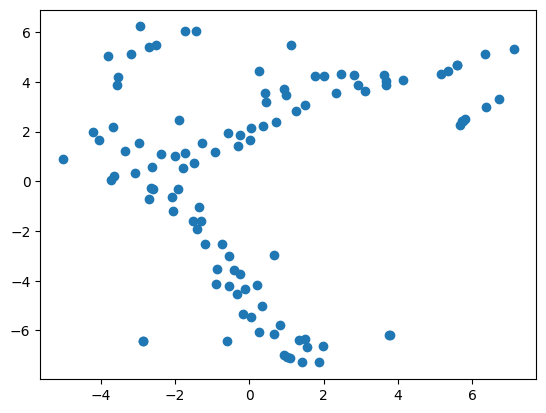

/home/nazanin/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


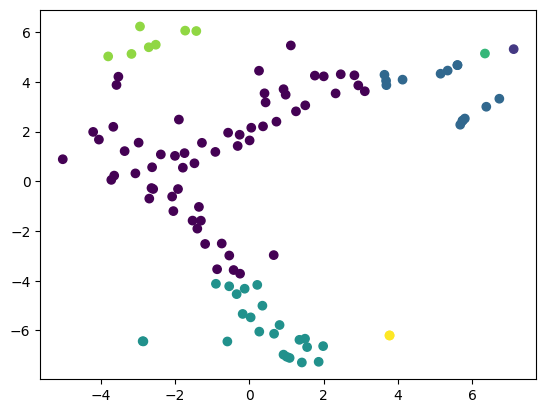

In [101]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=0).fit(embeddings_scaled)
labels = kmeans.labels_

# Visualize the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()